In [1]:
from __future__ import print_function
import theano
import theano.tensor as T
import numpy as np
import lasagne
import math
import matplotlib.pyplot as plt
from IPython import display
import random
import scipy
import json
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
# class GCNLayer(lasagne.layers.Layer):
#     def __init__(
#         self, incoming, A_hat, num_out_features=3,
#         W=lasagne.init.GlorotUniform(),
#         nonlinearity=lasagne.nonlinearities.sigmoid,
#         **kwargs
#     ):
#         
#         super(GCNLayer, self).__init__(incoming, **kwargs)
#         self.A_hat = A_hat
#         self.num_out_features = num_out_features
#         if nonlinearity is None:
#             nonlinearity = lasagne.nonlinearities.linear
#         self.nonlinearity = nonlinearity
#         
#         self.W = self.add_param(W, [incoming.output_shape[2], num_out_features], name="W")
#         
#     def get_output_shape_for(self, input_shape):
#         return (input_shape[0], input_shape[1], self.num_out_features)
#     
#     def get_output_for(self, input, **kwargs):
#         A_X = T.tensordot(self.A_hat, input, axes=[1, 1]).transpose(1, 0, 2)
#         Z = T.dot(A_X, self.W)
#         return self.nonlinearity(Z)
    
class GCNLayer(lasagne.layers.Layer):
    """
    A Graph Convolution Net layer.
    
    A_hat: A "square" 3-dimensional tensor, consisting of one or more normalized adjacency matrices, stacked in
        the second dimension. E.g. shape (2, 1000, 1000)
    num_out_features: The number of features to extract from the input.
    num_graphs: The number of different adjacency matrices contained in A_hat. Must be equal to A_hat.shape[0]
    nonlinearity: A theano-compatible nonlinearity function.
    """
    def __init__(
        self, incoming, A_hat, num_out_features=3, num_graphs=3,
        W=lasagne.init.GlorotUniform(),
        nonlinearity=lasagne.nonlinearities.sigmoid,
        **kwargs
    ):
        
        super(GCNLayer, self).__init__(incoming, **kwargs)
        self.A_hat = A_hat
        self.num_graphs = num_graphs
        self.num_out_features = num_out_features
        if nonlinearity is None:
            nonlinearity = lasagne.nonlinearities.linear
        self.nonlinearity = nonlinearity
        
        # print([self.num_graphs, incoming.output_shape[2], num_out_features])
        self.W = self.add_param(W, [self.num_graphs, incoming.output_shape[2], num_out_features], name="W")
        
    def get_output_shape_for(self, input_shape):
        return (input_shape[0], input_shape[1], self.num_out_features)
    
    def get_output_for(self, input, **kwargs):
        A_X = T.tensordot(self.A_hat, input, axes=[1, 1]).transpose(2, 1, 0, 3)
        Z = T.tensordot(A_X, self.W, axes=2)
        return self.nonlinearity(Z)
    
def special_softmax(t):
    """
    Function that applies the softmax function over the last dimension, keeping the remaining shape
    of the input tensor intact.
    """
    #num = T.exp(t)
    #den = num.sum(2, keepdims=True)
    #return num / den
    t2 = t.reshape((-1, t.shape[-1]))
    t2 = lasagne.nonlinearities.softmax(t2)
    return t2.reshape(t.shape)

class ConfusionMatrix(object):
    def __init__(self, preds, reals):
        assert len(preds) == len(reals)
        self.preds = preds
        self.reals = reals
        classes = sorted(set(preds) | set(reals))
        mat = np.zeros([len(classes), len(classes)], dtype="int")
        for real, pred in zip(reals, preds):
            mat[classes.index(real), classes.index(pred)] += 1
        self.mat = mat     
            
    def __str__(self):
        return str(self.mat)
    
    def bac(self):
        return (self.mat.diagonal() / self.mat.sum(1)).mean()

In [4]:
# with open("../Data/aa_indices.json") as f:
#     aa_indices = json.load(f)
# del aa_indices["cysteine"]

In [5]:
with open("../Data/Genome-wide/Measured_metabolite_indices.json") as infile:
    data_indices = json.load(infile)

In [6]:
loaded = np.load("../Data/NN_e_coli_data.npz")
data = dict(zip(loaded["arr_1"], loaded["arr_0"]))

In [7]:
len(data_indices)

310

In [8]:
# loaded = np.load("../Data/NN_e_coli_data.npz")
# data = dict(zip(loaded["arr_1"], loaded["arr_0"]))
X = data["X"].astype("float32")
Y = data["Y"].astype("float32")

splitpoint = int(X.shape[0] * 0.8)

order = random.sample(range(len(X)), len(X))
X = X[order]
Y = Y[order]

# Only predict measured metabolites
data_mask = np.zeros(shape=(Y.shape[0], Y.shape[1], 1))
data_mask[:, data_indices] = 1

Y = np.concatenate([(Y == 0).astype("int"), (Y == 1).astype("int")], axis=2)
Y = Y * data_mask

A_hat = data["adjacency"].astype("float32").transpose(2, 0, 1)

# Amplify knockout signal
X[:, :, 0] *= 3000

X_train = X[:splitpoint]
Y_train = Y[:splitpoint]
X_test  = X[splitpoint:]
Y_test  = Y[splitpoint:]

mask_train = data_mask[:splitpoint]
mask_test = data_mask[splitpoint:]

cat_counts = Y.sum(1).sum(0)
cat_factors = [cat_counts.max() / cnt for cnt in cat_counts]
print(cat_counts)
print(cat_counts[0] / sum(cat_counts))

train_cat_counts = Y_train.sum(1).sum(0)
train_cat_factors = [train_cat_counts.max() / cnt for cnt in train_cat_counts]
print(train_cat_counts)
print(train_cat_counts[0] / sum(train_cat_counts))

print(np.array(cat_counts) - np.array(train_cat_counts))

for i, fact in enumerate(train_cat_factors):
    mask_train[:, :, 0] *= (Y_train[:, :, i] == 1).astype("int") * (fact - 1) + 1

[311916.  17924.]
0.9456585010914382
[249622.  14188.]
0.9462188696410295
[62294.  3736.]


In [9]:
train_cat_factors

[1.0, 17.593882153932903]

In [10]:
# X_train = X_train["valine"]
# Y_train = Y_train["valine"]
# mask_train = mask_train["valine"]
# 
# X_test = X_test["valine"]
# Y_test = Y_test["valine"]
# mask_test = mask_test["valine"]

In [11]:
BATCH_SIZE = 100
NUM_INPUTS = X_train.shape[2]
NUM_OUTPUTS = Y.shape[-1]

x_sym = T.tensor3("x_sym")
y_sym = T.tensor3("y_sym")
#A_sym = T.matrix("A_sym")
A_sym = T.tensor3("A_sym")
ymask_sym = T.tensor3("ymask_sym")

l_in = lasagne.layers.InputLayer((None, X.shape[1], NUM_INPUTS))

l_1 = GCNLayer(l_in, A_sym, num_out_features=3, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 5
l_2 = GCNLayer(l_1, A_sym, num_out_features=5, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 7
l_3 = GCNLayer(l_2, A_sym, num_out_features=7, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 9
l_4 = GCNLayer(l_3, A_sym, num_out_features=9, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 13
l_5 = GCNLayer(l_4, A_sym, num_out_features=7, nonlinearity=lasagne.nonlinearities.leaky_rectify)

l_concat = lasagne.layers.ConcatLayer([
    l_1,
    l_2,
    l_3,
    l_4,
    # l_5
], axis=2)

# Dense: 50 units, leaky_rectify
# l_slice = lasagne.layers.SliceLayer(l_concat, indices=slice(0, 310), axis=1)
l_dense = lasagne.layers.DenseLayer(l_concat, num_units=20, num_leading_axes=2, nonlinearity=lasagne.nonlinearities.leaky_rectify)
l_drop = lasagne.layers.DropoutLayer(l_dense)

l_out = lasagne.layers.DenseLayer(l_drop, num_units=NUM_OUTPUTS, num_leading_axes=2, nonlinearity=special_softmax)


all_params = lasagne.layers.get_all_params(l_out, trainable=True)
print(sum(w.eval().size for w in all_params), "parameters")

908 parameters


In [12]:
l_dense.W.eval().shape

(24, 20)

In [13]:
#theano.config.exception_verbosity = "high"

In [14]:
print("Input layer", lasagne.layers.get_output(l_in, inputs={l_in: x_sym}).eval({x_sym: X[:100]}).shape)

print("Conv layer", lasagne.layers.get_output(l_1, inputs={l_in: x_sym}).eval({x_sym: X[:100], A_sym: A_hat}).shape)

print("Conv layer", lasagne.layers.get_output(l_2, inputs={l_in: x_sym}).eval({x_sym: X[:100], A_sym: A_hat}).shape)

print("Concat layer", lasagne.layers.get_output(l_concat, inputs={l_in: x_sym}).eval({x_sym: X[:100], A_sym: A_hat}).shape)

print("Dense layer", lasagne.layers.get_output(l_dense, inputs={l_in: x_sym}).eval({x_sym: X[:100], A_sym: A_hat}).shape)

print("Drop layer", lasagne.layers.get_output(l_drop, inputs={l_in: x_sym}).eval({x_sym: X[:100], A_sym: A_hat}).shape)

print("Output layer", lasagne.layers.get_output(l_out, inputs={l_in: x_sym}).eval({x_sym: X[:100], A_sym: A_hat}).shape)


Input layer (100, 4388, 3)


WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Conv layer (100, 4388, 3)
Conv layer (100, 4388, 5)
Concat layer (100, 4388, 24)
Dense layer (100, 4388, 20)
Drop layer (100, 4388, 20)
Output layer (100, 4388, 2)


In [15]:
# Retrieve network output
train_out = lasagne.layers.get_output(l_out, inputs={l_in: x_sym}, deterministic=False)
eval_out = lasagne.layers.get_output(l_out, inputs={l_in: x_sym}, deterministic=True)

all_params = lasagne.layers.get_all_params(l_out, trainable=True)

# cost = T.nnet.categorical_crossentropy(train_out+1e-8, y_sym).mean()
# cost = lasagne.objectives.squared_error(train_out, y_sym)
cost = lasagne.objectives.categorical_crossentropy(train_out+1e-8, y_sym)
cost = lasagne.objectives.aggregate(cost, weights=ymask_sym[:, :, 0], mode="mean")

# cost = lasagne.objectives.categorical_crossentropy(train_out+1e-8, y_sym)
# cost = lasagne.objectives.aggregate(cost, weights=ymask_sym[:, :, 0], mode="mean")

#cost_eval = lasagne.objectives.squared_error(eval_out, y_sym)

all_grads = T.grad(cost, all_params)

updates = lasagne.updates.adamax(all_grads, all_params, learning_rate=0.06) #, learning_rate=0.002)

f_eval = theano.function([x_sym, A_sym],
                     eval_out, on_unused_input='warn')

cost_eval = theano.function([x_sym, y_sym, A_sym, ymask_sym],
                     cost, on_unused_input='warn')

f_train = theano.function(
    [x_sym, y_sym, A_sym, ymask_sym],
    cost,
    updates=updates, on_unused_input='warn'
)

In [16]:
A_hat.shape

(3, 4388, 4388)

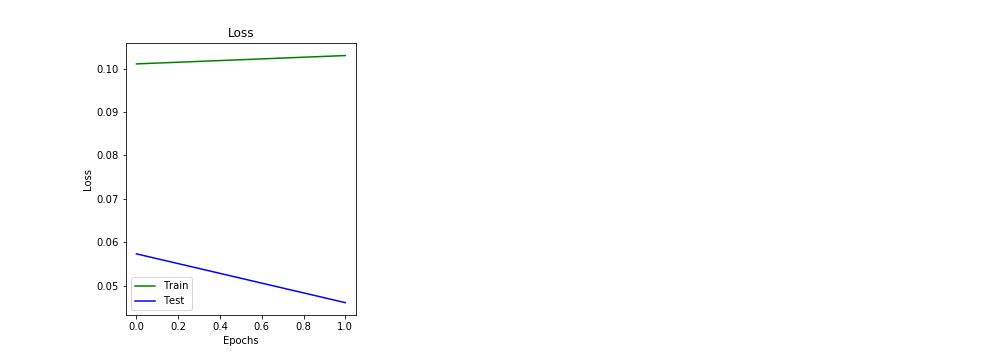

[[62177   117]
 [ 3717    19]]
0.5016037312944923

[[249102    520]
 [ 14107     81]]
0.5018129500894725
1


In [17]:
EPOCHS = 2
BATCH_SIZE = 100

train_losses = []
test_losses = []

best_bac = 0

for epoch in range(EPOCHS):
    for j in range(1):
        for i in range(math.ceil(len(X_train)/BATCH_SIZE)):
            x_batch = X_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
            y_batch = Y_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
            mask_batch = mask_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
            # print(x_batch.shape, y_batch.shape, mask_batch.shape)

            #f_train({x_sym: x_batch, y_sym: y_batch, A_sym: A_hat, ymask_sym: mask_batch})
            if epoch != 0:
                batch_train_loss = f_train(x_batch, y_batch, A_hat, mask_batch)
        
    test_output = f_eval(X_test, A_hat)
    train_output = f_eval(X_train, A_hat)
    
    test_loss = cost_eval(X_test, Y_test, A_hat, mask_test)
    train_loss = cost_eval(X_train, Y_train, A_hat, mask_train)
    #test_loss = (lasagne.objectives.categorical_crossentropy(test_output+1e-8, Y_test) * mask_test[:, :, 0]).sum() / mask_test.sum()
    #train_loss = 0.5 * (lasagne.objectives.categorical_crossentropy(train_output+1e-8, Y_train) * mask_train[:, :, 0]).sum() / mask_test.sum()
    
    #print((test_cost * mask_test).mean())
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    plt.figure(figsize=[14, 5])
    plt.subplot(1, 3, 1)
    plt.plot(list(range(epoch+1)), train_losses, "g", label="Train")
    plt.plot(list(range(epoch+1)), test_losses, "b", label="Test")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss")
    
    
    plt.savefig("out.png")
    plt.close()
    display.display(display.Image(filename="out.png"))
    
    test_predictions = test_output.argmax(-1).flatten()[mask_test.flatten().astype("bool")]
    real_classes = Y_test.argmax(-1).flatten()[mask_test.flatten().astype("bool")]
    # test_predictions = test_output.argmax(-1).flatten()[mask_test.flatten().astype("bool")]
    # real_classes = Y_test.argmax(-1).flatten()[mask_test.flatten().astype("bool")]
    
    conf = ConfusionMatrix(test_predictions, real_classes)
    print(conf)
    print(conf.bac())
    print("")
    if conf.bac() > best_bac:
        best_bac = conf.bac()
        best_pred = test_predictions
        best_output = test_output
        real_test_classes = real_classes
        best_epoch = epoch
    
    test_predictions = train_output.argmax(-1).flatten()[mask_train.flatten().astype("bool")]
    real_classes = Y_train.argmax(-1).flatten()[mask_train.flatten().astype("bool")]
    # test_predictions = train_output.argmax(-1).flatten()[mask_train.flatten().astype("bool")]
    # real_classes = Y_train.argmax(-1).flatten()[mask_train.flatten().astype("bool")]
    
    conf = ConfusionMatrix(test_predictions, real_classes)
    print(conf)
    print(conf.bac())
    
    print(epoch)
    
    display.clear_output(wait=True)

In [23]:
train_loss.shape

()

In [77]:
output_values = train_output[:, :, 1].flatten()[mask_train.flatten().astype("bool")]
output_values.shape

(263810,)

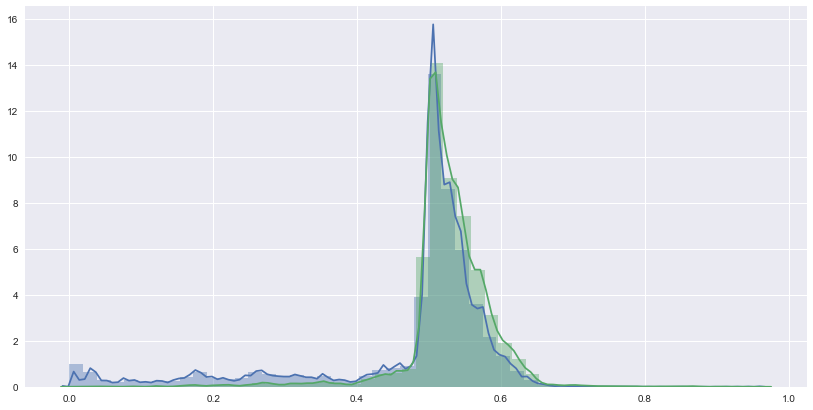

In [84]:
import seaborn as sbn

plt.figure(figsize=[14, 7])

plot_values = output_values[real_classes == 0]
sbn.distplot(plot_values, kde=True)

plot_values = output_values[real_classes == 1]
sbn.distplot(plot_values, kde=True)

In [61]:
4388 * 851

3734188

In [186]:
test_predictions = test_output.argmax(-1).flatten()[mask_test.flatten().astype("bool")]
real_classes = Y_test.argmax(-1).flatten()[mask_test.flatten().astype("bool")]
print(test_predictions.shape)
print(real_classes.shape)

(66030,)
(66030,)


In [187]:
conf = ConfusionMatrix(test_predictions, real_classes)
print(conf)
print(conf.bac())

[[49469 12822]
 [ 2924   815]]
0.506066194957


In [157]:
test_loss = cost_eval(X_test, Y_test, A_hat, mask_test)

ValueError: Input dimension mis-match. (input[0].shape[1] = 213, input[1].shape[1] = 4388)
Apply node that caused the error: Elemwise{mul,no_inplace}(InplaceDimShuffle{x,0,1}.0, ymask_sym)
Toposort index: 129
Inputs types: [TensorType(float64, (True, False, False)), TensorType(float64, 3D)]
Inputs shapes: [(1, 213, 4388), (213, 4388, 1)]
Inputs strides: [(7477152, 35104, 8), (35104, 8, 8)]
Inputs values: ['not shown', 'not shown']
Inputs type_num: [12, 12]
Outputs clients: [[Sum{acc_dtype=float64}(Elemwise{mul,no_inplace}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/krisj/anaconda/envs/cfb_old/lib/python3.4/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/krisj/anaconda/envs/cfb_old/lib/python3.4/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/Users/krisj/anaconda/envs/cfb_old/lib/python3.4/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/krisj/anaconda/envs/cfb_old/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/krisj/anaconda/envs/cfb_old/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/krisj/anaconda/envs/cfb_old/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-144-ada4fb01b576>", line 10, in <module>
    cost = lasagne.objectives.aggregate(cost, weights=ymask_sym, mode="mean")
  File "/Users/krisj/anaconda/envs/cfb_old/lib/python3.4/site-packages/lasagne/objectives.py", line 237, in aggregate
    return loss.mean()

Debugprint of the apply node: 
Elemwise{mul,no_inplace} [id A] <TensorType(float64, 3D)> ''   
 |InplaceDimShuffle{x,0,1} [id B] <TensorType(float64, (True, False, False))> ''   
 | |Sum{axis=[2], acc_dtype=float64} [id C] <TensorType(float64, matrix)> ''   
 |   |Elemwise{Composite{(i0 * log((i1 + i2)))}}[(0, 2)] [id D] <TensorType(float64, 3D)> ''   
 |     |y_sym [id E] <TensorType(float64, 3D)>
 |     |TensorConstant{(1, 1, 1) of 1e-08} [id F] <TensorType(float64, (True, True, True))>
 |     |Reshape{3} [id G] <TensorType(float64, 3D)> ''   
 |       |Softmax [id H] <TensorType(float64, matrix)> ''   
 |       | |Reshape{2} [id I] <TensorType(float64, matrix)> ''   
 |       |   |Elemwise{Add}[(0, 0)] [id J] <TensorType(float64, 3D)> ''   
 |       |   | |Reshape{3} [id K] <TensorType(float64, 3D)> ''   
 |       |   | | |Dot22 [id L] <TensorType(float64, matrix)> ''   
 |       |   | | | |Reshape{2} [id M] <TensorType(float64, matrix)> ''   
 |       |   | | | | |Elemwise{Composite{(i0 * ((i1 * (i2 + i3) * Composite{Cast{float64}(LT(i0, i1))}(i4, i5)) + (i6 * Abs((i2 + i3)) * Composite{Cast{float64}(LT(i0, i1))}(i4, i5))))}}[(0, 2)] [id N] <TensorType(float64, 3D)> ''   
 |       |   | | | | | |TensorConstant{(1, 1, 1) of 2.0} [id O] <TensorType(float64, (True, True, True))>
 |       |   | | | | | |TensorConstant{(1, 1, 1) of 0.505} [id P] <TensorType(float64, (True, True, True))>
 |       |   | | | | | |Reshape{3} [id Q] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | |Dot22 [id R] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | |Reshape{2} [id S] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | |Join [id T] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | | | | |TensorConstant{2} [id U] <TensorType(int8, scalar)>
 |       |   | | | | | | | | | |Elemwise{Composite{((i0 * i1) + (i2 * Abs(i1)))}}[(0, 1)] [id V] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | | | | | |TensorConstant{(1, 1, 1) of 0.505} [id P] <TensorType(float64, (True, True, True))>
 |       |   | | | | | | | | | | |Reshape{3} [id W] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | | | | | | |Dot22 [id X] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | | | | | |Reshape{2} [id Y] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | | | | | | |InplaceDimShuffle{2,1,0,3} [id Z] <TensorType(float64, 4D)> ''   
 |       |   | | | | | | | | | | | | | | |Reshape{4} [id BA] <TensorType(float64, 4D)> ''   
 |       |   | | | | | | | | | | | | | |   |Dot22 [id BB] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | | | | | | |   | |Reshape{2} [id BC] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | | | | | | |   | | |InplaceDimShuffle{0,2,1} [id BD] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | | | | | | | | |   | | | |A_sym [id BE] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | | | |   | | |MakeVector{dtype='int64'} [id BF] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | | | | | | |   | |   |Elemwise{Mul}[(0, 0)] [id BG] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |   | |   | |Shape_i{0} [id BH] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |   | |   | | |A_sym [id BE] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | | | |   | |   | |Shape_i{2} [id BI] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |   | |   |   |A_sym [id BE] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | | | |   | |   |Shape_i{1} [id BJ] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |   | |     |A_sym [id BE] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | | | |   | |Reshape{2} [id BK] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | | | | | | |   |   |InplaceDimShuffle{1,0,2} [id BL] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | | | | | | | | |   |   | |x_sym [id BM] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | | | |   |   |MakeVector{dtype='int64'} [id BN] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | | | | | | |   |     |Shape_i{1} [id BO] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |   |     | |x_sym [id BM] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | | | |   |     |Elemwise{mul,no_inplace} [id BP] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |   |       |Shape_i{2} [id BQ] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |   |       | |x_sym [id BM] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | | | |   |       |Shape_i{0} [id BR] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |   |         |x_sym [id BM] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | | | |   |MakeVector{dtype='int64'} [id BS] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | | | | | | |     |Shape_i{0} [id BH] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |     |Shape_i{2} [id BI] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |     |Shape_i{0} [id BR] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |     |Shape_i{2} [id BQ] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |MakeVector{dtype='int64'} [id BT] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | | | | | |   |Elemwise{Mul}[(0, 0)] [id BU] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | |   | |Shape_i{0} [id BR] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | |   | |Shape_i{2} [id BI] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | |   |Elemwise{Mul}[(0, 0)] [id BV] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | |     |Shape_i{2} [id BQ] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | |     |Shape_i{0} [id BH] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | |Reshape{2} [id BW] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | | | | |   |W [id BX] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | |   |MakeVector{dtype='int64'} [id BY] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | | | | |     |Elemwise{Mul}[(0, 0)] [id BZ] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | |     | |Shape_i{0} [id CA] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | |     | | |W [id BX] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | |     | |Shape_i{1} [id CB] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | |     |   |W [id BX] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | |     |Shape_i{2} [id CC] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | |       |W [id BX] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | |MakeVector{dtype='int64'} [id CD] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | | | |   |Shape_i{0} [id BR] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | |   |Shape_i{2} [id BI] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | |   |Shape_i{2} [id CC] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | |TensorConstant{(1, 1, 1) of 0.495} [id CE] <TensorType(float64, (True, True, True))>
 |       |   | | | | | | | | | |Elemwise{Composite{((i0 * i1) + (i2 * Abs(i1)))}}[(0, 1)] [id CF] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | | | | | |TensorConstant{(1, 1, 1) of 0.505} [id P] <TensorType(float64, (True, True, True))>
 |       |   | | | | | | | | | | |Reshape{3} [id CG] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | | | | | | |Dot22 [id CH] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | | | | | |Reshape{2} [id CI] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | | | | | | |InplaceDimShuffle{2,1,0,3} [id CJ] <TensorType(float64, 4D)> ''   
 |       |   | | | | | | | | | | | | | | |Reshape{4} [id CK] <TensorType(float64, 4D)> ''   
 |       |   | | | | | | | | | | | | | |   |Dot22 [id CL] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | | | | | | |   | |Reshape{2} [id BC] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | | | | | | |   | |Reshape{2} [id CM] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | | | | | | |   |   |InplaceDimShuffle{1,0,2} [id CN] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | | | | | | | | |   |   | |Elemwise{Composite{((i0 * i1) + (i2 * Abs(i1)))}}[(0, 1)] [id V] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | | | | | | | | |   |   |MakeVector{dtype='int64'} [id CO] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | | | | | | |   |     |Shape_i{2} [id BI] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |   |     |Elemwise{mul,no_inplace} [id CP] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |   |       |Shape_i{2} [id CC] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |   |       |Shape_i{0} [id BR] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |   |MakeVector{dtype='int64'} [id CQ] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | | | | | | |     |Shape_i{0} [id BH] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |     |Shape_i{2} [id BI] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |     |Shape_i{0} [id BR] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |     |Shape_i{2} [id CC] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |MakeVector{dtype='int64'} [id CR] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | | | | | |   |Elemwise{Mul}[(0, 0)] [id BU] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | |   |Elemwise{mul,no_inplace} [id CS] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | |     |Shape_i{2} [id CC] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | |     |Shape_i{0} [id BH] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | |Reshape{2} [id CT] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | | | | |   |W [id CU] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | |   |MakeVector{dtype='int64'} [id CV] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | | | | |     |Elemwise{Mul}[(0, 0)] [id CW] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | |     | |Shape_i{0} [id CX] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | |     | | |W [id CU] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | |     | |Shape_i{1} [id CY] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | |     |   |W [id CU] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | |     |Shape_i{2} [id CZ] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | |       |W [id CU] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | |MakeVector{dtype='int64'} [id DA] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | | | |   |Shape_i{0} [id BR] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | |   |Shape_i{2} [id BI] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | |   |Shape_i{2} [id CZ] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | |TensorConstant{(1, 1, 1) of 0.495} [id CE] <TensorType(float64, (True, True, True))>
 |       |   | | | | | | | | | |Elemwise{Composite{((i0 * i1) + (i2 * Abs(i1)))}}[(0, 1)] [id DB] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | | | | | |TensorConstant{(1, 1, 1) of 0.505} [id P] <TensorType(float64, (True, True, True))>
 |       |   | | | | | | | | | | |Reshape{3} [id DC] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | | | | | | |Dot22 [id DD] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | | | | | |Reshape{2} [id DE] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | | | | | | |InplaceDimShuffle{2,1,0,3} [id DF] <TensorType(float64, 4D)> ''   
 |       |   | | | | | | | | | | | | | | |Reshape{4} [id DG] <TensorType(float64, 4D)> ''   
 |       |   | | | | | | | | | | | | | |   |Dot22 [id DH] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | | | | | | |   | |Reshape{2} [id BC] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | | | | | | |   | |Reshape{2} [id DI] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | | | | | | |   |   |InplaceDimShuffle{1,0,2} [id DJ] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | | | | | | | | |   |   | |Elemwise{Composite{((i0 * i1) + (i2 * Abs(i1)))}}[(0, 1)] [id CF] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | | | | | | | | |   |   |MakeVector{dtype='int64'} [id DK] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | | | | | | |   |     |Shape_i{2} [id BI] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |   |     |Elemwise{mul,no_inplace} [id DL] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |   |       |Shape_i{2} [id CZ] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |   |       |Shape_i{0} [id BR] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |   |MakeVector{dtype='int64'} [id DM] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | | | | | | |     |Shape_i{0} [id BH] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |     |Shape_i{2} [id BI] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |     |Shape_i{0} [id BR] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |     |Shape_i{2} [id CZ] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | | |MakeVector{dtype='int64'} [id DN] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | | | | | |   |Elemwise{Mul}[(0, 0)] [id BU] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | |   |Elemwise{Mul}[(0, 0)] [id DO] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | |     |Shape_i{2} [id CZ] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | |     |Shape_i{0} [id BH] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | | |Reshape{2} [id DP] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | | | | |   |W [id DQ] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | |   |MakeVector{dtype='int64'} [id DR] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | | | | |     |Elemwise{Mul}[(0, 0)] [id DS] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | |     | |Shape_i{0} [id DT] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | |     | | |W [id DQ] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | |     | |Shape_i{1} [id DU] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | |     |   |W [id DQ] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | |     |Shape_i{2} [id DV] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | | |       |W [id DQ] <TensorType(float64, 3D)>
 |       |   | | | | | | | | | | | |MakeVector{dtype='int64'} [id DW] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | | | |   |Shape_i{0} [id BR] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | |   |Shape_i{2} [id BI] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | |   |Shape_i{2} [id DV] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | | | |TensorConstant{(1, 1, 1) of 0.495} [id CE] <TensorType(float64, (True, True, True))>
 |       |   | | | | | | | | | |Elemwise{Composite{((i0 * i1) + (i2 * Abs(i1)))}}[(0, 1)] [id DX] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | | | |   |TensorConstant{(1, 1, 1) of 0.505} [id P] <TensorType(float64, (True, True, True))>
 |       |   | | | | | | | | |   |Reshape{3} [id DY] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | | | |   | |Dot22 [id DZ] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | |   | | |Reshape{2} [id EA] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | |   | | | |InplaceDimShuffle{2,1,0,3} [id EB] <TensorType(float64, 4D)> ''   
 |       |   | | | | | | | | |   | | | | |Reshape{4} [id EC] <TensorType(float64, 4D)> ''   
 |       |   | | | | | | | | |   | | | |   |Dot22 [id ED] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | |   | | | |   | |Reshape{2} [id BC] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | |   | | | |   | |Reshape{2} [id EE] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | |   | | | |   |   |InplaceDimShuffle{1,0,2} [id EF] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | | | |   | | | |   |   | |Elemwise{Composite{((i0 * i1) + (i2 * Abs(i1)))}}[(0, 1)] [id DB] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | | | |   | | | |   |   |MakeVector{dtype='int64'} [id EG] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | |   | | | |   |     |Shape_i{2} [id BI] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   | | | |   |     |Elemwise{mul,no_inplace} [id EH] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   | | | |   |       |Shape_i{2} [id DV] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   | | | |   |       |Shape_i{0} [id BR] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   | | | |   |MakeVector{dtype='int64'} [id EI] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | |   | | | |     |Shape_i{0} [id BH] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   | | | |     |Shape_i{2} [id BI] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   | | | |     |Shape_i{0} [id BR] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   | | | |     |Shape_i{2} [id DV] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   | | | |MakeVector{dtype='int64'} [id EJ] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | |   | | |   |Elemwise{Mul}[(0, 0)] [id BU] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   | | |   |Elemwise{Mul}[(0, 0)] [id EK] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   | | |     |Shape_i{2} [id DV] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   | | |     |Shape_i{0} [id BH] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   | | |Reshape{2} [id EL] <TensorType(float64, matrix)> ''   
 |       |   | | | | | | | | |   | |   |W [id EM] <TensorType(float64, 3D)>
 |       |   | | | | | | | | |   | |   |MakeVector{dtype='int64'} [id EN] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | |   | |     |Elemwise{Mul}[(0, 0)] [id EO] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   | |     | |Shape_i{0} [id EP] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   | |     | | |W [id EM] <TensorType(float64, 3D)>
 |       |   | | | | | | | | |   | |     | |Shape_i{1} [id EQ] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   | |     |   |W [id EM] <TensorType(float64, 3D)>
 |       |   | | | | | | | | |   | |     |Shape_i{2} [id ER] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   | |       |W [id EM] <TensorType(float64, 3D)>
 |       |   | | | | | | | | |   | |MakeVector{dtype='int64'} [id ES] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | | |   |   |Shape_i{0} [id BR] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   |   |Shape_i{2} [id BI] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   |   |Shape_i{2} [id ER] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | | |   |TensorConstant{(1, 1, 1) of 0.495} [id CE] <TensorType(float64, (True, True, True))>
 |       |   | | | | | | | | |MakeVector{dtype='int64'} [id ET] <TensorType(int64, vector)> ''   
 |       |   | | | | | | | |   |Elemwise{Mul}[(0, 0)] [id BU] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | |   |Elemwise{Add}[(0, 0)] [id EU] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | |     |Shape_i{2} [id CC] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | |     |Shape_i{2} [id CZ] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | |     |Shape_i{2} [id DV] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | |     |Shape_i{2} [id ER] <TensorType(int64, scalar)> ''   
 |       |   | | | | | | | |W [id EV] <TensorType(float64, matrix)>
 |       |   | | | | | | |MakeVector{dtype='int64'} [id EW] <TensorType(int64, vector)> ''   
 |       |   | | | | | |   |Shape_i{0} [id BR] <TensorType(int64, scalar)> ''   
 |       |   | | | | | |   |Shape_i{2} [id BI] <TensorType(int64, scalar)> ''   
 |       |   | | | | | |   |Shape_i{1} [id EX] <TensorType(int64, scalar)> ''   
 |       |   | | | | | |     |W [id EV] <TensorType(float64, matrix)>
 |       |   | | | | | |InplaceDimShuffle{x,x,0} [id EY] <TensorType(float64, (True, True, False))> ''   
 |       |   | | | | | | |b [id EZ] <TensorType(float64, vector)>
 |       |   | | | | | |mrg_uniform{TensorType(float64, 3D),inplace}.1 [id FA] <TensorType(float64, 3D)> ''   
 |       |   | | | | | | |<TensorType(int32, matrix)> [id FB] <TensorType(int32, matrix)>
 |       |   | | | | | | |MakeVector{dtype='int64'} [id EW] <TensorType(int64, vector)> ''   
 |       |   | | | | | |TensorConstant{(1, 1, 1) of 0.5} [id FC] <TensorType(float32, (True, True, True))>
 |       |   | | | | | |TensorConstant{(1, 1, 1) of 0.495} [id CE] <TensorType(float64, (True, True, True))>
 |       |   | | | | |MakeVector{dtype='int64'} [id FD] <TensorType(int64, vector)> ''   
 |       |   | | | |   |Elemwise{Mul}[(0, 0)] [id BU] <TensorType(int64, scalar)> ''   
 |       |   | | | |   |Shape_i{1} [id EX] <TensorType(int64, scalar)> ''   
 |       |   | | | |W [id FE] <TensorType(float64, matrix)>
 |       |   | | |MakeVector{dtype='int64'} [id FF] <TensorType(int64, vector)> ''   
 |       |   | |   |Shape_i{0} [id BR] <TensorType(int64, scalar)> ''   
 |       |   | |   |Shape_i{2} [id BI] <TensorType(int64, scalar)> ''   
 |       |   | |   |Shape_i{1} [id FG] <TensorType(int64, scalar)> ''   
 |       |   | |     |W [id FE] <TensorType(float64, matrix)>
 |       |   | |InplaceDimShuffle{x,x,0} [id FH] <TensorType(float64, (True, True, False))> ''   
 |       |   |   |b [id FI] <TensorType(float64, vector)>
 |       |   |MakeVector{dtype='int64'} [id FJ] <TensorType(int64, vector)> ''   
 |       |     |TensorConstant{-1} [id FK] <TensorType(int64, scalar)>
 |       |     |Shape_i{1} [id FG] <TensorType(int64, scalar)> ''   
 |       |MakeVector{dtype='int64'} [id FF] <TensorType(int64, vector)> ''   
 |ymask_sym [id FL] <TensorType(float64, 3D)>

Storage map footprint:
 - A_sym, Input, Shape: (3, 4388, 4388), ElemSize: 8 Byte(s), TotalSize: 462109056 Byte(s)
 - x_sym, Input, Shape: (213, 4388, 3), ElemSize: 8 Byte(s), TotalSize: 22431456 Byte(s)
 - y_sym, Input, Shape: (213, 4388, 2), ElemSize: 8 Byte(s), TotalSize: 14954304 Byte(s)
 - ymask_sym, Input, Shape: (213, 4388, 1), ElemSize: 8 Byte(s), TotalSize: 7477152 Byte(s)
 - InplaceDimShuffle{x,0,1}.0, Shape: (1, 213, 4388), ElemSize: 8 Byte(s), TotalSize: 7477152 Byte(s)
 - mrg_uniform{TensorType(float64, 3D),inplace}.0, Shape: (15360, 6), ElemSize: 4 Byte(s), TotalSize: 368640 Byte(s)
 - <TensorType(int32, matrix)>, Shared Input, Shape: (15360, 6), ElemSize: 4 Byte(s), TotalSize: 368640 Byte(s)
 - W, Shared Input, Shape: (24, 30), ElemSize: 8 Byte(s), TotalSize: 5760 Byte(s)
 - W, Shared Input, Shape: (3, 7, 9), ElemSize: 8 Byte(s), TotalSize: 1512 Byte(s)
 - W, Shared Input, Shape: (3, 5, 7), ElemSize: 8 Byte(s), TotalSize: 840 Byte(s)
 - W, Shared Input, Shape: (30, 2), ElemSize: 8 Byte(s), TotalSize: 480 Byte(s)
 - W, Shared Input, Shape: (3, 3, 5), ElemSize: 8 Byte(s), TotalSize: 360 Byte(s)
 - b, Shared Input, Shape: (30,), ElemSize: 8 Byte(s), TotalSize: 240 Byte(s)
 - W, Shared Input, Shape: (3, 3, 3), ElemSize: 8 Byte(s), TotalSize: 216 Byte(s)
 - b, Shared Input, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - TensorConstant{(1, 1, 1) of 0.495}, Shape: (1, 1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1, 1) of 2.0}, Shape: (1, 1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1, 1, 1) of 0.505}, Shape: (1, 1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1, 1) of 1e-08}, Shape: (1, 1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1, 1) of 0.5}, Shape: (1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{2}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 TotalSize: 514827253.0 Byte(s) 0.479 GB
 TotalSize inputs: 507350101.0 Byte(s) 0.473 GB



In [393]:
print(ConfusionMatrix(best_pred, Y_test.argmax(-1).flatten()[mask_test.flatten().astype("bool")]))

[[20  4]
 [ 5  7]]


In [73]:
lasagne.objectives.categorical_crossentropy(test_output, Y_test).eval().shape

(31, 2803)

In [74]:
mask_test.shape

(31, 2803, 1)

In [ ]:
# pFBA fluxes: Much less overfitting (train_loss < test_loss) than with model.solve() fluxes :S

In [221]:
correctness = Y_test.argmax(2) == test_output.argmax(2)
train_correctness = Y_train.argmax(2) == train_output.argmax(2)

In [222]:
node_mask = (mask_test != 0)[0, :, 0]

In [223]:
aa_order = [
    'alanine',
    'arginine',
    'asparagine',
    'aspartate',
    'glutamine',
    'glutamate',
    'glycine',
    'histidine',
    'isoleucine',
    'leucine',
    'lysine',
    'methionine',
    'phenylalanine',
    'proline',
    'serine',
    'threonine',
    'tryptophan',
    'tyrosine',
    'valine'
]

In [16]:
correctness.shape

(31, 2803)

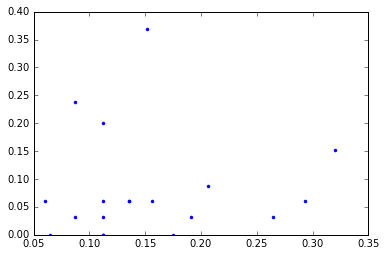

In [17]:
plt.plot(Y_test.argmax(2)[:, node_mask].var(0),
        test_output.argmax(2)[:, node_mask].var(0), ".")

In [224]:
def prediction_plots():
    node_mask = (mask_test != 0)[0, :, 0]
    
    fig = plt.figure(figsize=[14, 14])
    
    guess = np.ones_like(test_output)
    
    correctness = (Y_test.argmax(2) == test_output.argmax(2))[:, node_mask]
    #correctness = (Y_test.argmax(2) == guess[:, :, 0])[:, node_mask]
    train_correctness = (Y_train.argmax(2) == train_output.argmax(2))[:, node_mask]
    
    # Bar chart
    aa_accuracies = correctness.astype("int").mean(0)
    ax = fig.add_subplot(2, 2, 1)
    ax.plot([-1, 19], [1/3, 1/3], "--r")
    plt.bar(np.arange(0, len(aa_accuracies))-0.5, aa_accuracies)
    plt.xlim(-1, 19)
    plt.xticks(range(len(aa_accuracies)), rotation="vertical")
    ax.set_xticklabels(aa_order)
    
    plt.ylabel("Acc")
    
    # Var vs Acc
    ax = fig.add_subplot(2, 2, 2)
    var = Y_test[:, node_mask].argmax(2).var(0)
    
    plt.plot(var, aa_accuracies, ".")
    plt.plot([var.min(), var.max()], [1/3, 1/3], "--r")
    
    plt.ylim([0, 1])
    
    plt.xlabel("Variance")
    plt.ylabel("Acc")
    
    # Highest class frequency vs accuracy
    ax = fig.add_subplot(2, 2, 3)
    top_freq = Y_train[:, node_mask].sum(0).max(1) / Y_train.shape[0]
    
    plt.plot(top_freq, aa_accuracies, ".")
    plt.plot([top_freq.min(), top_freq.max()], [top_freq.min(), top_freq.max()], "r--")
    
    plt.xlabel("Freq of most frequent class")
    plt.ylabel("Acc")

In [61]:
bacs = np.zeros([len(aa_order), 3])
for i in range(3):
    bacs[:, i] = (train_correctness[:, node_mask] & (Y_train[:, node_mask].argmax(2) == i)).sum(0)
    

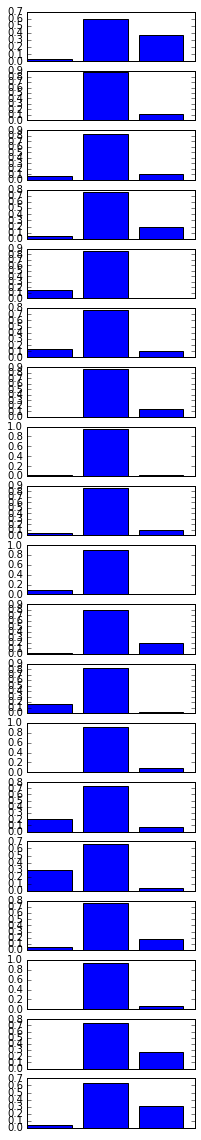

In [63]:
plt.figure(figsize=[3, 20])
freqs = Y[:, node_mask].sum(0) / Y.shape[0]
for i, aa in enumerate(aa_order):
    plt.subplot(19, 1, i+1)
    
    plt.bar(np.arange(0, 3, 1), freqs[i])
    plt.xticks([])
    

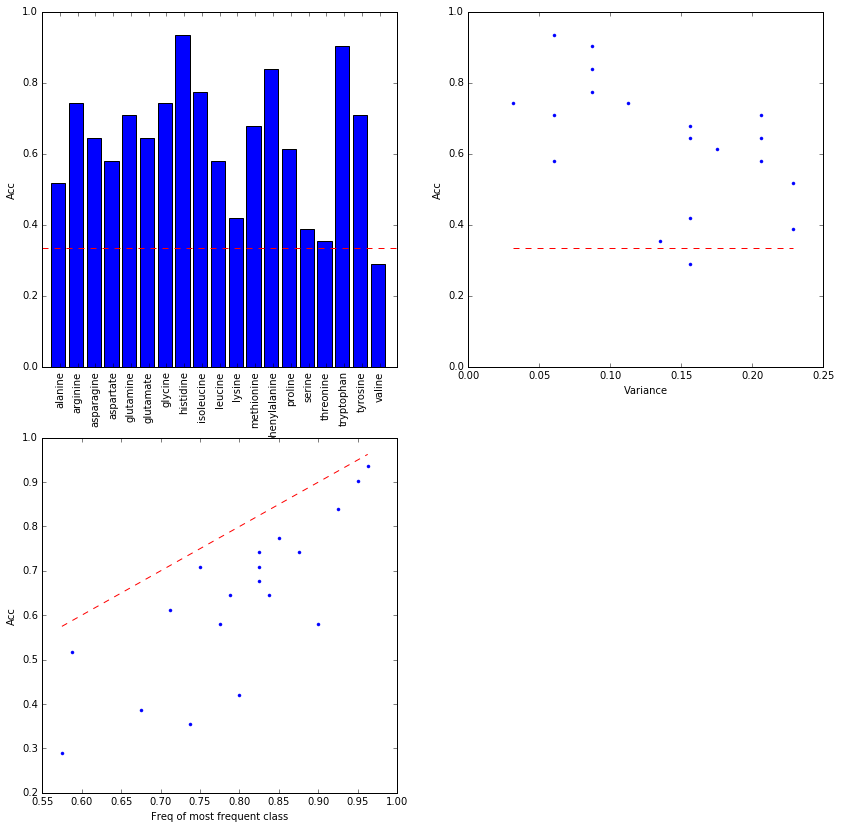

In [225]:
prediction_plots()

In [38]:
(test_output[:, node_mask].argmax(2) == 2).sum()

641

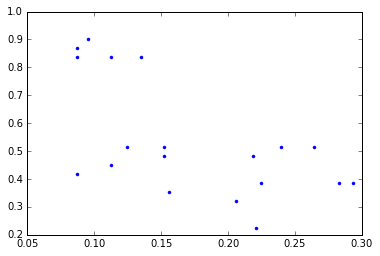

In [18]:
plt.plot(Y_test.argmax(2)[:, node_mask].var(0),
            (correctness * (mask_test != 0).astype("int")[:, :, 0]).mean(0)[node_mask], ".")

In [92]:
(correctness * (mask_test != 0).astype("int")[:, :, 0]).mean(0)[node_mask]

array([ 0.41935484,  0.22580645,  0.41935484,  0.25806452,  0.35483871,
        0.29032258,  0.80645161,  0.90322581,  0.74193548,  0.48387097,
        0.64516129,  0.25806452,  0.74193548,  0.32258065,  0.38709677,
        0.22580645,  0.70967742,  0.29032258,  0.19354839])

In [59]:
test_output.shape

(31, 2803, 3)

Necessary?: Flux coupling, fluxes, specific knock-out fluxes?
Generative??
What does it fail at predicting?
Take another look at Uwe paper

In [562]:
loaded = np.load("../Data/NN_data.npz")

data = dict(zip(loaded["arr_1"], loaded["arr_0"]))
X = data["X"].astype("float32")
Y = data["Y"].astype("float32")
weight_mask = data["weight_mask"]
cat_Y = data["cat_Y"].astype("float32")
affected = data["affected"].astype("bool")

splitpoint = 75
X = X[affected]
Y = Y[affected]
cat_Y = cat_Y[affected]

order = random.sample(range(len(X)), len(X))
X = X[order]
Y = Y[order]
cat_Y = cat_Y[order]

# Merge increase and decrease
cat_Y = np.stack([cat_Y[:, :, 1], cat_Y[:, :, 0] + cat_Y[:, :, 2]], axis=2)

for aa, idx in aa_indices.items():
    print("%2s" % int(cat_Y[:splitpoint, idx, 1].sum()), end="  ")

print("")
    
for aa, idx in aa_indices.items():
    print("%2s" % int(cat_Y[splitpoint:, idx, 1].sum()), end="  ")
print("")

13  31   4  22   5  17   9  11  20  12  31  16  10   7  17   8  19  28  12  
 7   9   1   8   2  10   5   5   9   3  13   6   5   3   9   1   7   9   7  


In [559]:
# np.savez("../Data/Permuted_data1.npz", X=X, Y=Y, cat_Y=cat_Y)

In [556]:
# Train on all aa's simultaneously. Predict conc changes from all other concs and gene KO.
# All aa's have same GCN layer parameters, and individual dense layers

loaded = np.load("../Data/Permuted_data1.npz")

splitpoint = 75

X_train = {}
Y_train = {}
mask_train = {}

X_test = {}
Y_test = {}
mask_test = {}

for aa, idx in aa_indices.items():
    
    X = loaded["X"]
    Y = loaded["Y"]
    cat_Y = loaded["cat_Y"]
    covariates = Y.copy()
    
    # Only predict one metabolite
    aa_mask = np.zeros_like(Y)
    aa_mask[:, aa_indices[aa]] = 1
    Y = Y * aa_mask
    
    mask = (Y != 0).astype("float")
    cat_Y = cat_Y * mask

    covariates[:, aa_indices[aa]] = 0
    X = np.concatenate([X, covariates], axis=2)
    
    # Amplify knockout signal
    X[:, :, 0] *= 3000
    
    Y = cat_Y
    
    X_train[aa] = X[:splitpoint]
    Y_train[aa] = Y[:splitpoint]
    X_test[aa] = X[splitpoint:]
    Y_test[aa] = Y[splitpoint:]

    mask_train[aa] = mask[:splitpoint]
    mask_test[aa] = mask[splitpoint:]
    
    train_cat_counts = Y_train[aa].sum(1).sum(0)
    train_cat_factors = [train_cat_counts.max() / cnt for cnt in train_cat_counts]
    #print(train_cat_counts)
    #print(np.array(cat_counts) - np.array(train_cat_counts))

    for i, fact in enumerate(train_cat_factors):
        mask_train[aa][:, :, 0] *= (Y_train[aa][:, :, i] == 1).astype("int") * (fact - 1) + 1
        
first_aa = list(aa_indices)[0]
        
NUM_INPUTS = X_train[first_aa].shape[2]
NUM_OUTPUTS = Y_train[first_aa].shape[-1]
x_sym = T.tensor3("x_sym")
y_sym = T.tensor3("y_sym")
#A_sym = T.matrix("A_sym")
A_sym = T.tensor3("A_sym")
ymask_sym = T.tensor3("ymask_sym")

l_in = lasagne.layers.InputLayer((None, A_hat.shape[0], NUM_INPUTS))
l_1 = GCNLayer(l_in, A_sym, num_out_features=5, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 5
l_2 = GCNLayer(l_1, A_sym, num_out_features=7, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 7
l_3 = GCNLayer(l_2, A_sym, num_out_features=9, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 9
l_4 = GCNLayer(l_3, A_sym, num_out_features=9, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 13
l_5 = GCNLayer(l_4, A_sym, num_out_features=7, nonlinearity=lasagne.nonlinearities.leaky_rectify)
l_concat = lasagne.layers.ConcatLayer([l_1, l_2, l_3, l_4, l_5], axis=2)

aa_output_layers = {}
f_train = {}
f_eval = {}
cost_eval = {}

for aa, idx in aa_indices.items():
    # if aa not in ["valine"]:
    #     continue
    print(aa)
    
    l_slice = lasagne.layers.SliceLayer(l_concat, indices=idx, axis=1)
    l_dense = lasagne.layers.DenseLayer(l_slice, num_units=30, num_leading_axes=1, nonlinearity=lasagne.nonlinearities.leaky_rectify)
    l_drop = lasagne.layers.DropoutLayer(l_dense)

    l_out = lasagne.layers.DenseLayer(l_drop, num_units=NUM_OUTPUTS, num_leading_axes=1, nonlinearity=special_softmax)
    
    aa_output_layers[aa] = l_out
    
    # Retrieve network output
    train_out = lasagne.layers.get_output(l_out, inputs={l_in: x_sym}, deterministic=False)
    eval_out = lasagne.layers.get_output(l_out, inputs={l_in: x_sym}, deterministic=True)

    all_params = lasagne.layers.get_all_params(l_out, trainable=True)

    # cost = T.nnet.categorical_crossentropy(train_out+1e-8, y_sym).mean()
    # cost = lasagne.objectives.squared_error(train_out, y_sym)
    cost = lasagne.objectives.categorical_crossentropy(train_out+1e-8, y_sym[:, aa_indices[aa]])
    cost = lasagne.objectives.aggregate(cost, weights=ymask_sym[:, aa_indices[aa], 0], mode="mean")

    # cost = lasagne.objectives.categorical_crossentropy(train_out+1e-8, y_sym)
    # cost = lasagne.objectives.aggregate(cost, weights=ymask_sym[:, :, 0], mode="mean")

    #cost_eval = lasagne.objectives.squared_error(eval_out, y_sym)

    all_grads = T.grad(cost, all_params)

    updates = lasagne.updates.adamax(all_grads, all_params, learning_rate=0.06)#, learning_rate=0.002) #, learning_rate=0.002)

    f_eval[aa] = theano.function([x_sym, A_sym],
                         eval_out, on_unused_input='warn')

    cost_eval[aa] = theano.function([x_sym, y_sym, A_sym, ymask_sym],
                         cost, on_unused_input='warn')

    f_train[aa] = theano.function(
        [x_sym, y_sym, A_sym, ymask_sym],
        cost,
        updates=updates, on_unused_input='warn'
    )

methionine
valine
histidine
proline
tryptophan
aspartate
arginine
glutamine
tyrosine
isoleucine
alanine
lysine
glycine
leucine
glutamate
phenylalanine
threonine
serine
asparagine


In [504]:
Y_train["valine"][:, aa_indices["valine"]].sum(0)

array([ 48.,  27.])

In [531]:
all_params[0] is l_1.W

True

In [525]:
f_eval["valine"](X_train["valine"], A_hat_2)

array([[ 0.48001891,  0.51998109],
       [ 0.48001744,  0.51998256],
       [ 0.47998582,  0.52001418],
       [ 0.48001913,  0.51998087],
       [ 0.47961679,  0.52038321],
       [ 0.4800187 ,  0.5199813 ],
       [ 0.48001917,  0.51998083],
       [ 0.48001865,  0.51998135],
       [ 0.47855098,  0.52144902],
       [ 0.4800192 ,  0.5199808 ],
       [ 0.48001905,  0.51998095],
       [ 0.480019  ,  0.519981  ],
       [ 0.48001868,  0.51998132],
       [ 0.48001907,  0.51998093],
       [ 0.48001599,  0.51998401],
       [ 0.48001861,  0.51998139],
       [ 0.48001886,  0.51998114],
       [ 0.48001924,  0.51998076],
       [ 0.47891675,  0.52108325],
       [ 0.47855096,  0.52144904],
       [ 0.48001929,  0.51998071],
       [ 0.48001656,  0.51998344],
       [ 0.47855102,  0.52144898],
       [ 0.47998559,  0.52001441],
       [ 0.48001913,  0.51998087],
       [ 0.48002022,  0.51997978],
       [ 0.47855104,  0.52144896],
       [ 0.47855092,  0.52144908],
       [ 0.4797561 ,

In [557]:
train_losses = []
test_losses = []

bacs_train = {}
bacs_test = {}

for epoch in range(EPOCHS):
    epoch_train_losses = []
    epoch_test_losses = []
    for aa in sorted(aa_indices):
        for j in range(1):
            for i in range(math.ceil(len(X_train[aa])/BATCH_SIZE)):
                x_batch = X_train[aa][i*BATCH_SIZE: (i+1)*BATCH_SIZE]
                y_batch = Y_train[aa][i*BATCH_SIZE: (i+1)*BATCH_SIZE]
                mask_batch = mask_train[aa][i*BATCH_SIZE: (i+1)*BATCH_SIZE]

                #f_train({x_sym: x_batch, y_sym: y_batch, A_sym: A_hat, ymask_sym: mask_batch})
                if epoch != 0:
                    batch_train_loss = f_train[aa](x_batch, y_batch, A_hat_2, mask_batch)

        test_output = f_eval[aa](X_test[aa], A_hat_2)
        train_output = f_eval[aa](X_train[aa], A_hat_2)
    
        test_loss = cost_eval[aa](X_test[aa], Y_test[aa], A_hat_2, mask_test[aa])
        train_loss = cost_eval[aa](X_train[aa], Y_train[aa], A_hat_2, mask_train[aa])
        
        epoch_train_losses.append(train_loss)
        epoch_test_losses.append(test_loss)
        
        test_predictions = test_output.argmax(-1)
        real_classes = Y_test[aa].argmax(-1)[:, aa_indices[aa]]
        
        conf = ConfusionMatrix(test_predictions, real_classes)
        bacs_test[aa] = conf.bac()
        
        train_predictions = train_output.argmax(-1)
        real_classes = Y_train[aa].argmax(-1)[:, aa_indices[aa]]
    
        conf = ConfusionMatrix(train_predictions, real_classes)
        bacs_train[aa] = conf.bac()
        
    train_losses.append(sum(epoch_train_losses)/len(aa_indices))
    test_losses.append(sum(epoch_test_losses)/len(aa_indices))   
    
    fig = plt.figure(figsize=[14, 5])
    plt.subplot(2, 2, 1)
    plt.plot(list(range(epoch+1)), train_losses, "g", label="Train")
    plt.plot(list(range(epoch+1)), test_losses, "b", label="Test")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss")
    
    ax = fig.add_subplot(2, 2, 3)
    ax.plot([-1, 19], [1/2, 1/2], "--r")
    plt.bar(np.arange(0, len(bacs_test))-0.5, [bacs_test[a] for a in sorted(bacs_test)])
    plt.xlim(-1, 19)
    plt.xticks(range(len(bacs_test)), rotation="vertical")
    ax.set_xticklabels(sorted(bacs_test))
    plt.ylim([0, 1])
    
    ax = fig.add_subplot(2, 2, 4)
    ax.plot([-1, 19], [1/2, 1/2], "--r")
    plt.bar(np.arange(0, len(bacs_train))-0.5, [bacs_train[a] for a in sorted(bacs_train)])
    plt.xlim(-1, 19)
    plt.xticks(range(len(bacs_train)), rotation="vertical")
    ax.set_xticklabels(sorted(bacs_train))
    plt.ylim([0, 1])
    
    plt.savefig("out.png")
    plt.close()
    display.display(display.Image(filename="out.png"))
    
    print(sum(bacs_test.values()) / len(bacs_test))
    
    print(epoch)
    
    display.clear_output(wait=True)

KeyboardInterrupt: 

In [ ]:
aa_datasets = {}

In [622]:
# Train on each compound seperately
# Using reaction KO and other metabolite concentrations as input

loaded = np.load("../Data/NN_data.npz")

for aa in ["tryptophan"]: #aa_indices:
    print(aa)

    data = dict(zip(loaded["arr_1"], loaded["arr_0"]))
    X = data["X"].astype("float32")
    Y = data["Y"].astype("float32")
    weight_mask = data["weight_mask"]
    cat_Y = data["cat_Y"].astype("float32")
    affected = data["affected"].astype("bool")

    splitpoint = 75

    X = X[affected]
    Y = Y[affected]
    cat_Y = cat_Y[affected]


    order = random.sample(range(len(X)), len(X))
    X = X[order]
    Y = Y[order]
    cat_Y = cat_Y[order]
    
    covariates = Y.copy()

    # Merge increase and decrease
    cat_Y = np.stack([cat_Y[:, :, 1], cat_Y[:, :, 0] + cat_Y[:, :, 2]], axis=2)

    # Only predict one metabolite
    aa_mask = np.zeros_like(Y)
    aa_mask[:, aa_indices[aa]] = 1
    Y = Y * aa_mask

    mask = (Y != 0).astype("float")
    cat_Y = cat_Y * mask

    
    covariates[:, aa_indices[aa]] = 0
    X = np.concatenate([X, covariates], axis=2)

    #mask[:, :, 0] = mask[:, :, 0] / ((cat_Y[:, :, 1] == 1).astype("float") * 3 + 1)

    #mask = np.stack([weight_mask]).transpose([1, 2, 0])
    #mask = mask * np.abs(Y)
    #mask = np.zeros_like(Y, dtype="int32")
    #mask[:, 256] = 1
    A_hat = data["A_hat"].astype("float32")
    A_hat_2 = data["double_A"].astype("float32")

    Y = cat_Y
    #for i, fact in enumerate(cat_factors):
    #    mask[:, :, 0] *= (cat_Y[:, :, i] == 1).astype("int") * (fact - 1) + 1

    # Amplify knockout signal
    X[:, :, 0] *= 1000

    X_train = X[:splitpoint]
    Y_train = Y[:splitpoint]
    X_test = X[splitpoint:]
    Y_test = Y[splitpoint:]

    mask_train = mask[:splitpoint]
    mask_test = mask[splitpoint:]

    cat_counts = Y.sum(1).sum(0)
    cat_factors = [cat_counts.max() / cnt for cnt in cat_counts]
    print(cat_counts)

    train_cat_counts = Y_train.sum(1).sum(0)
    train_cat_factors = [train_cat_counts.max() / cnt for cnt in train_cat_counts]
    print(train_cat_counts)
    print(np.array(cat_counts) - np.array(train_cat_counts))

    for i, fact in enumerate(train_cat_factors):
        mask_train[:, :, 0] *= (Y_train[:, :, i] == 1).astype("int") * (fact - 1) + 1
        
    dataset = {
        "X_train": X_train,
        "Y_train": Y_train,
        "X_test": X_test,
        "Y_test": Y_test,
        "mask_train": mask_train,
        "mask_test": mask_test
    }
    aa_datasets[aa] = dataset

tryptophan
[ 104.    7.]
[ 71.   4.]
[ 33.   3.]


In [623]:
# for aa, ds in aa_datasets.items():
#     np.savez("../Data/AA_datasets/"+aa+".npz", **ds)

In [567]:
result_dict = {}
for aa in aa_indices:
    print(aa)
    results = []

    for training_round in range(4):
        print("  ", training_round)
        NUM_INPUTS = X_train.shape[2]
        NUM_OUTPUTS = Y.shape[-1]

        x_sym = T.tensor3("x_sym")
        y_sym = T.tensor3("y_sym")
        #A_sym = T.matrix("A_sym")
        A_sym = T.tensor3("A_sym")
        ymask_sym = T.tensor3("ymask_sym")

        l_in = lasagne.layers.InputLayer((None, A_hat.shape[0], NUM_INPUTS))

        l_1 = GCNLayer(l_in, A_sym, num_out_features=3, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 5
        l_2 = GCNLayer(l_1, A_sym, num_out_features=5, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 7
        l_3 = GCNLayer(l_2, A_sym, num_out_features=7, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 9
        l_4 = GCNLayer(l_3, A_sym, num_out_features=9, nonlinearity=lasagne.nonlinearities.leaky_rectify) # 13
        l_5 = GCNLayer(l_4, A_sym, num_out_features=7, nonlinearity=lasagne.nonlinearities.leaky_rectify)

        l_concat = lasagne.layers.ConcatLayer([l_1, l_2, l_3, l_4], axis=2)

        # Dense: 50 units, leaky_rectify
        l_slice = lasagne.layers.SliceLayer(l_concat, indices=aa_indices[aa], axis=1)
        l_dense = lasagne.layers.DenseLayer(l_slice, num_units=30, num_leading_axes=1, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        l_drop = lasagne.layers.DropoutLayer(l_dense)

        l_out = lasagne.layers.DenseLayer(l_drop, num_units=NUM_OUTPUTS, num_leading_axes=1, nonlinearity=special_softmax)


        all_params = lasagne.layers.get_all_params(l_out, trainable=True)

        # Retrieve network output
        train_out = lasagne.layers.get_output(l_out, inputs={l_in: x_sym}, deterministic=False)
        eval_out = lasagne.layers.get_output(l_out, inputs={l_in: x_sym}, deterministic=True)

        all_params = lasagne.layers.get_all_params(l_out, trainable=True)

        # cost = T.nnet.categorical_crossentropy(train_out+1e-8, y_sym).mean()
        # cost = lasagne.objectives.squared_error(train_out, y_sym)
        cost = lasagne.objectives.categorical_crossentropy(train_out+1e-8, y_sym[:, aa_indices[aa]])
        cost = lasagne.objectives.aggregate(cost, weights=ymask_sym[:, aa_indices[aa], 0], mode="mean")

        # cost = lasagne.objectives.categorical_crossentropy(train_out+1e-8, y_sym)
        # cost = lasagne.objectives.aggregate(cost, weights=ymask_sym[:, :, 0], mode="mean")

        #cost_eval = lasagne.objectives.squared_error(eval_out, y_sym)

        all_grads = T.grad(cost, all_params)

        updates = lasagne.updates.adamax(all_grads, all_params, learning_rate=0.06)#, learning_rate=0.002) #, learning_rate=0.002)

        f_eval = theano.function([x_sym, A_sym],
                             eval_out, on_unused_input='warn')

        cost_eval = theano.function([x_sym, y_sym, A_sym, ymask_sym],
                             cost, on_unused_input='warn')

        f_train = theano.function(
            [x_sym, y_sym, A_sym, ymask_sym],
            cost,
            updates=updates, on_unused_input='warn'
        )

        EPOCHS = 40
        BATCH_SIZE = 10

        train_losses = []
        test_losses = []

        best_bac = 0
        
        dataset = aa_datasets[aa]
        X_train = dataset["X_train"]
        Y_train = dataset["Y_train"]
        X_test = dataset["X_test"]
        Y_test = dataset["Y_test"]
        mask_train = dataset["mask_train"]
        mask_test = dataset["mask_test"]

        for epoch in range(EPOCHS):
            for j in range(1):
                for i in range(math.ceil(len(X_train)/BATCH_SIZE)):
                    x_batch = X_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
                    y_batch = Y_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
                    mask_batch = mask_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]

                    #f_train({x_sym: x_batch, y_sym: y_batch, A_sym: A_hat, ymask_sym: mask_batch})
                    if epoch != 0:
                        batch_train_loss = f_train(x_batch, y_batch, A_hat_2, mask_batch)

            test_output = f_eval(X_test, A_hat_2)
            train_output = f_eval(X_train, A_hat_2)

            test_loss = cost_eval(X_test, Y_test, A_hat_2, mask_test)
            train_loss = cost_eval(X_train, Y_train, A_hat_2, mask_train)
            #test_loss = (lasagne.objectives.categorical_crossentropy(test_output+1e-8, Y_test) * mask_test[:, :, 0]).sum() / mask_test.sum()
            #train_loss = 0.5 * (lasagne.objectives.categorical_crossentropy(train_output+1e-8, Y_train) * mask_train[:, :, 0]).sum() / mask_test.sum()

            #print((test_cost * mask_test).mean())

            train_losses.append(train_loss)
            test_losses.append(test_loss)

            # plt.figure(figsize=[14, 5])
            # plt.subplot(1, 3, 1)
            # plt.plot(list(range(epoch+1)), train_losses, "g", label="Train")
            # plt.plot(list(range(epoch+1)), test_losses, "b", label="Test")
            # plt.legend()
            # plt.xlabel("Epochs")
            # plt.ylabel("Loss")
            # plt.title("Loss")


            # plt.savefig("out.png")
            # plt.close()
            # display.display(display.Image(filename="out.png"))
            test_predictions = test_output.argmax(-1)#.flatten()[mask_test.flatten().astype("bool")]
            real_classes = Y_test.argmax(-1)[:, aa_indices[aa]]#.flatten()[mask_test.flatten().astype("bool")]
            # test_predictions = test_output.argmax(-1).flatten()[mask_test.flatten().astype("bool")]
            # real_classes = Y_test.argmax(-1).flatten()[mask_test.flatten().astype("bool")]

            conf = ConfusionMatrix(test_predictions, real_classes)
            # print(conf)
            # print(conf.bac())
            # print("")
            if conf.bac() > best_bac:
                best_bac = conf.bac()
                best_pred = test_predictions
                best_output = test_output
                real_test_classes = real_classes
                best_epoch = epoch

            test_predictions = train_output.argmax(-1)#.flatten()[mask_train.flatten().astype("bool")]
            real_classes = Y_train.argmax(-1)[:, aa_indices[aa]]#.flatten()[mask_train.flatten().astype("bool")]
            # test_predictions = train_output.argmax(-1).flatten()[mask_train.flatten().astype("bool")]
            # real_classes = Y_train.argmax(-1).flatten()[mask_train.flatten().astype("bool")]

            conf = ConfusionMatrix(test_predictions, real_classes)
            # print(conf)
            # print(conf.bac())

            # print(epoch)

            # display.clear_output(wait=True)

        results.append({
                "best_bac": best_bac,
                "best_pred": best_pred,
                "best_output": best_output,
                "real_test_classes": real_test_classes,
                "best_epoch": best_epoch
        })
    result_dict[aa] = results

methionine
   0
   1
   2
   3
valine
   0
   1
   2
   3
histidine
   0
   1
   2
   3
proline
   0
   1
   2
   3
tryptophan
   0
   1
   2
   3
aspartate
   0
   1
   2
   3
arginine
   0
   1
   2
   3
glutamine
   0
   1
   2
   3
tyrosine
   0
   1
   2
   3
isoleucine
   0
   1
   2
   3
alanine
   0
   1
   2
   3
lysine
   0
   1
   2
   3
glycine
   0
   1
   2
   3
leucine
   0
   1
   2
   3
glutamate
   0
   1
   2
   3
phenylalanine
   0
   1
   2
   3
threonine
   0
   1
   2
   3
serine
   0
   1
   2
   3
asparagine
   0
   1
   2
   3


In [568]:
for aa in aa_indices:
    print(aa)
    for r in result_dict[aa]:
        conf = ConfusionMatrix(r["best_pred"], r["real_test_classes"])
        print(conf.bac())
        print(conf)
        print(r["best_epoch"])
        print("")

methionine
0.6
[[31  0]
 [ 4  1]]
0

0.554838709677
[[22  9]
 [ 3  2]]
9

0.612903225806
[[ 7 24]
 [ 0  5]]
10

0.5
[[31  0]
 [ 5  0]]
1

valine
0.600334448161
[[17  6]
 [ 7  6]]
32

0.650501672241
[[14  9]
 [ 4  9]]
15

0.595317725753
[[15  8]
 [ 6  7]]
34

0.573578595318
[[14  9]
 [ 6  7]]
18

histidine
0.720588235294
[[32  2]
 [ 1  1]]
38

0.558823529412
[[21 13]
 [ 1  1]]
9

0.617647058824
[[25  9]
 [ 1  1]]
2

0.661764705882
[[28  6]
 [ 1  1]]
11

proline
0.570234113712
[[ 5 18]
 [ 1 12]]
8

0.688963210702
[[14  9]
 [ 3 10]]
24

0.678929765886
[[10 13]
 [ 1 12]]
10

0.628762541806
[[13 10]
 [ 4  9]]
10

tryptophan
0.560606060606
[[26  7]
 [ 2  1]]
5

0.575757575758
[[16 17]
 [ 1  2]]
0

0.530303030303
[[24  9]
 [ 2  1]]
23

0.5
[[33  0]
 [ 3  0]]
1

aspartate
0.62962962963
[[19  8]
 [ 4  5]]
17

0.648148148148
[[14 13]
 [ 2  7]]
35

0.592592592593
[[11 16]
 [ 2  7]]
12

0.592592592593
[[11 16]
 [ 2  7]]
24

arginine
0.716666666667
[[28  2]
 [ 3  3]]
30

0.716666666667
[[28  2]
 [ 

In [572]:
for aa in aa_indices:
    print(aa, ":", max([d["best_bac"] for d in result_dict[aa]]))

methionine : 0.612903225806
valine : 0.650501672241
histidine : 0.720588235294
proline : 0.688963210702
tryptophan : 0.575757575758
aspartate : 0.648148148148
arginine : 0.733333333333
glutamine : 0.835483870968
tyrosine : 0.580357142857
isoleucine : 0.803225806452
alanine : 0.727424749164
lysine : 0.705357142857
glycine : 0.738709677419
leucine : 0.738709677419
glutamate : 0.680769230769
phenylalanine : 0.772727272727
threonine : 0.688461538462
serine : 0.666666666667
asparagine : 0.51935483871


In [414]:
result_dict["proline"]

[{'best_bac': 0,
  'best_epoch': 36,
  'best_output': array([[  8.74057098e-01,   1.25942902e-01],
         [  4.58311317e-01,   5.41688683e-01],
         [  5.72001333e-01,   4.27998667e-01],
         [  8.38903444e-02,   9.16109656e-01],
         [  6.55559102e-01,   3.44440898e-01],
         [  8.41168898e-01,   1.58831102e-01],
         [  2.30288581e-01,   7.69711419e-01],
         [  7.92186468e-01,   2.07813532e-01],
         [  8.42383930e-01,   1.57616070e-01],
         [  4.46947209e-04,   9.99553053e-01],
         [  4.31807020e-01,   5.68192980e-01],
         [  1.69200867e-01,   8.30799133e-01],
         [  7.81572882e-01,   2.18427118e-01],
         [  9.93302088e-01,   6.69791236e-03],
         [  6.13464928e-01,   3.86535072e-01],
         [  8.85395990e-01,   1.14604010e-01],
         [  8.97792318e-01,   1.02207682e-01],
         [  6.22410163e-01,   3.77589837e-01],
         [  1.55228021e-01,   8.44771979e-01],
         [  5.23424416e-01,   4.76575584e-01],
        

In [599]:
(X_train[:, :, [0, 4]][:, :, 1] == X_train[:, :, 4]).all()

True

In [625]:
aa_datasets["alanine"]["X_test"][:, :, 4].any()

True

In [589]:
data["X"].shape

(341, 2803, 4)

In [601]:
X_train[:, :, 4].any()

False

In [633]:
(A_hat_2[:1][0] == A_hat_2[0]).all()

True

In [634]:
len(A_hat_2)

2

In [ ]:
import os

In [ ]:
os.listdir()

In [ ]:
with open("../../")